# Import Packages

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

pd.set_option('display.max_columns', None)
%matplotlib inline

C:\Users\micha\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\micha\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\micha\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Import fungsi repository yang diperlukan

In [2]:
def timer(start_time, header='\nProgram Schedule'):
    end_time = pd.to_datetime('now', utc=True) + pd.Timedelta('07:00:00')
    print('\n\033[1m' + header + ':\033[0m')
    print(start_time.strftime('Start   : %Y-%m-%d %I:%M:%S %p'))
    print(end_time.strftime('Finish  : %Y-%m-%d %I:%M:%S %p'))
    run_time = str(end_time - start_time)
    idx1 = run_time.find(' ', 3) + 1
    idx2 = run_time.find('.')
    print('Runtime :', run_time[idx1 : idx2], '\n')
    
def category_counts(df, col, header=None, decimal=1, asc=False, top=10, style=True):
    header = col if header is None else header
    table = df[col].value_counts().rename_axis(header).reset_index(name='Count')
    table['Percentage'] = table['Count'] / table['Count'].sum(axis=0)
    
    if asc:
        table.sort_values(by=header, inplace=True)
        table.reset_index(drop=True, inplace=True)
        
    table['Cumulative'] = table['Percentage'].cumsum()
    table.index += 1
    
    table = table.head(top)
    
    if style:
        pct = '{:.' + str(decimal) + '%}'
        table = table.style.format({'Count': '{:,}', 'Percentage': pct, 'Cumulative': pct})
        
    return table

def memory_usage(df, unit='MiB'):
    size = df.memory_usage(index=True, deep=True).sum()
    
    if unit == 'GiB':
        print('Memory usage:', f'{size / 2**30:,.2f}', unit)
    elif unit == 'MiB':
        print('Memory usage:', f'{size / 2**20:,.2f}', unit)
    else:
        print('Memory usage:', f'{size / 2**10:,.2f}', 'kiB')

from scipy.stats import chi2_contingency

def target_pivot(df, var, target, count, percent=True, ncat=10, alpha=0.05, style=True):
    n = len(df[var].unique())
    
    if n <= ncat:
        pvt = pd.pivot_table(df, values=count, index=var, columns=target, aggfunc='count')
        pval = chi2_contingency(pvt)[1]
        
        print('P-value:', f'{pval:.2%}')
        
        if pval <= alpha:
            print('\033[1mConclusion:\033[0m There is a statistically significant association between\033[1m', var, 
                  '\033[0mand\033[1m', target, '\033[0m\n')
            
            print('The differences between the observed counts and the expected counts:')
            display((pvt - chi2_contingency(pvt)[3]).round(1))
            
        else:
            print('\033[1mConclusion:\033[0m There is NOT enough evidence to conclude that\033[1m', var, 
                  '\033[0mand\033[1m', target, '\033[0mare associated\n')
        
        if percent:
            cols = pvt.columns
            total = pvt.sum(1)

            for col in cols:
                pvt[col] = pvt[col] / total
                
                if col in [1, True, 'Y', 'Yes', 'YES']:
                    pos = col
                
            pvt.sort_values(by=pos, ascending=False, inplace=True) 
            
        if style:
            fmt = '{:,.2%}' if percent else '{:,}'
            pvt = pvt.style.format(fmt)
            
        print('Pivot table between variable\033[1m', var, '\033[0mand\033[1m', target, '\033[0m(in percent):')
            
        display(pvt)
    
    else:
        print('Pivot table for a high cardinality variable will not be shown.', 
              'Variable\033[1m', var, '\033[0mhas', f'{n:,}', 'unique values.')

import matplotlib

#matplotlib.use('TkAgg')
    
def boxplot(data, variable, category, threshold=0.8, plotsize=(7,7), colors=['green', 'red'], limits=None):
    if len(data[category].unique()) == 2:
        colors = colors
        alpha = 0.5
        
        x, y = data[[variable, category]].T.values
    else:
        colors = None
        alpha = 1
    
    fig, ax = plt.subplots(figsize=plotsize)
    
    colors = colors if len(data[category].unique()) == 2 else None
    alpha = 0.5 if len(data[category].unique()) == 2 else 1
    
    sns.boxplot(x=category, y=variable, data=data, ax=ax, 
                showmeans=True, meanline=True, palette=colors, width=0.3,
                flierprops=dict(marker='o', markerfacecolor='red', markeredgecolor='white', alpha=alpha),
                meanprops=dict(linestyle='-', linewidth=2, color='orange'),
                medianprops=dict(linestyle='-', linewidth=2, color='white'), 
                boxprops=dict(linewidth=0, alpha=0.7))
    
    ax.set(ylim=limits)
    
    plt.yticks(rotation=0)
    
    plt.show()
    
import phik
import ppscore as pps

def predictive_power(data, variables, target=None, plotsize=(20,20)):
    cols = variables + [target] if target != None else variables
    
    corrs = pps.matrix(data[cols]).pivot(columns='x', index='y', values='ppscore')
    print('\033[1mPredictive Power Score Matrix:\033[0m')
        
    fig, ax = plt.subplots(figsize=plotsize)
    ax = sns.heatmap(corrs, annot=True, fmt='.1%', cmap='RdYlGn', cbar_kws={'shrink': 0.8}, 
                     vmin=0, center=0.5, vmax=1, square=True, linewidths=0.1, linecolor='white')
    plt.show()
    
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(data, variables, style=True):
    # Add constant to the GLM variables
    X = add_constant(data[variables])
    vif_values = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]
    vif_df = pd.DataFrame({'Variable': variables, 'VIF': vif_values})
    vif_df = vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)
    vif_df.index += 1

    if style:
        vif_df = vif_df.style.format({'VIF': '{:,.2f}'})
        
    return vif_df

def table(data, values, index, columns=None, top=10, icol=0, asc=True, style=True, idxwidth='125px', colwidth='50px'):
    print('\n\033[1mInfo in form of', values, 'level:\033[0m')
    
    if columns is None:
        tab1 = data.groupby(index, as_index=False).agg(Count=(values, 'nunique'))
        tab1['Percentage'] = tab1['Count'] / tab1['Count'].sum(axis=0)

        if asc:
            tab1.sort_values(by='Count', ascending=False, inplace=True, ignore_index=True)

        tab1['Cumulative'] = tab1['Percentage'].cumsum()
        tab1.index += 1

        tab1 = tab1.loc[tab1['Count'] > 0].head(top)

        if style:
            pct = '{:.1%}'
            tab1 = tab1.style.format({'Count': '{:,}', 'Percentage': pct, 'Cumulative': pct})

        return tab1
    
    else:
        tab1 = pd.pivot_table(data=data, values=values, index=index, columns=columns, aggfunc='nunique', fill_value=0)
        
        if asc:
            tab1.sort_values(by=tab1.columns[icol], ascending=False, inplace=True)

        tab2 = tab1 / tab1.sum()
        tab3 = tab1.div(tab1.sum(axis=1), axis=0)

        if style:
            index_styles = [{'selector': 'th.row_heading', 'props': 'width: ' + idxwidth + ';'},
                            {'selector': 'th.col_heading', 'props': 'width: ' + colwidth + ';'}]

            display(tab1.head(top).style.format('{:,.0f}').set_table_styles(index_styles))
            display(tab2.head(top).style.format('{:,.1%}').set_table_styles(index_styles))
            display(tab3.head(top).style.format('{:,.1%}').set_table_styles(index_styles))
        else:
            return tab1, tab2, tab3

# Import Datasets

In [3]:
agent_data = pd.read_parquet('agent.parquet')
beneficiary_data = pd.read_parquet('beneficiary.parquet')
client_data = pd.read_parquet('client.parquet')
policy_data = pd.read_parquet('policy.parquet')

# Data Cleaning and Preparation

Membuat 2 kolom baru pada data beneficiary.

    1. Kolom BENEFICIARY_TYPE_PRIMARY yang memiliki value 1 apabila BENEFICIARY_TYPE merupakan Primary dan 0 apabila tidak
    2. Kolom BENEFICIARY_TYPE_SECONDARY yang memiliki value 1 apabila BENEFICIARY_TYPE merupakan SECONDARY dan 0 apabila tidak
  
Kolom-kolom baru tersebut akan dipakai dan digabungkan dengan data yang akan dipakai dalam pemodelan. Untuk sementara, kolom-kolom tersebut dipisah dan dibuatkan kedalam dataframe baru yaitu 'benedata'

In [4]:
beneficiary_data['BENEFICIARY_TYPE_PRIMARY'] = np.where(beneficiary_data['BENEFICIARY_TYPE'] == 'Primary', 1, 0)
beneficiary_data['BENEFICIARY_TYPE_SECONDARY'] = np.where(beneficiary_data['BENEFICIARY_TYPE'] == 'Secondary', 1, 0)
benedata = beneficiary_data[['CLIENT_ID', 'BENEFICIARY_TYPE_PRIMARY', 'BENEFICIARY_TYPE_SECONDARY']]
benedata = benedata.groupby('CLIENT_ID').sum().reset_index(drop=False)

Mengubah data-data waktu menjadi datetime

In [5]:
agent_data['DOB'] = pd.to_datetime(agent_data['DOB'])
agent_data['CONTRACT_DATE'] = pd.to_datetime(agent_data['CONTRACT_DATE'])
agent_data['TERMINATION_DATE'] = pd.to_datetime(agent_data['TERMINATION_DATE'])

client_data['DOB'] = pd.to_datetime(client_data['DOB'])

policy_data['APPLICATION_DATE'] = pd.to_datetime(policy_data['APPLICATION_DATE'])
policy_data['ISSUE_DATE'] = pd.to_datetime(policy_data['ISSUE_DATE'])

Melihat apakah ada data kosong pada policy_data

In [6]:
policy_data.isnull().sum()

POLICY_ID           0
CLIENT_ID           0
APPLICATION_DATE    0
ISSUE_DATE          0
POLICY_STATUS       0
PRODUCT_CODE        0
PRODUCT_TYPE        0
PAYMENT_TYPE        0
PAYMENT_TERM        0
PREMIUM             0
RIDER_COUNT         0
AGENT_ID            0
dtype: int64

Menampilkan tabel untuk melihat tanggal aplikasi terawal dan terakhir pada masing-masing produk yang terjual pada policy_data

In [7]:
policy_data.groupby('PRODUCT_CODE').agg(FIRST_APPLICATION_DATE=('APPLICATION_DATE','min'),
                                LAST_APPLICATION_DATE=('APPLICATION_DATE','max'))

FIRST_APPLICATION_DATE LAST_APPLICATION_DATE
PRODUCT_CODE                                             
P01                      2014-12-02            2019-12-23
P02                      2014-12-02            2019-12-19
P03                      2014-12-04            2019-12-15
P04                      2014-12-06            2019-12-21
P05                      2014-12-06            2019-12-22
P06                      2014-12-07            2019-12-21
P07                      2014-12-07            2019-12-21
P08                      2014-12-08            2019-12-23
P09                      2014-12-08            2019-12-24
P10                      2014-12-08            2019-12-17
P11                      2014-12-09            2019-12-23
P12                      2014-12-10            2019-12-19
P13                      2014-12-10            2019-12-21
P14                      2014-12-10            2019-12-24
P15                      2014-12-13            2019-12-19
P16                      2014-12-14            2019-12-23
P17                      2014-12-14            2019-12-12
P18                      2014-12-15            2019-12-22
P19                      2014-12-16            2019-12-15
P20                      2014-12-19            2019-12-26
P21                      2015-01-13            2019-12-15
P22                      2015-01-22            2019-12-15
P23                      2015-08-18            2019-12-14
P24                      2015-08-20            2019-12-24
P25                      2015-08-25            2019-12-18
P26                      2016-03-28            2019-11-29
P27                      2019-02-11            2019-12-30
P28                      2019-02-12            2019-12-27
P29                      2019-02-12            2019-12-26
P30                      2019-02-12            2019-12-30
P31                      2019-02-13            2019-12-29
P32                      2019-02-15            2019-12-27
P33                      2019-02-17            2019-12-20

Membuat filter untuk produk yang terjual hanya hingga awal tahun 2015 lalu membuatnya menjadi tipe data kategorikal

In [8]:
#SET PRODUCT CODE DARI 1 - 22
products = ['P' + str(i).zfill(2) for i in range (1,23)]
policy_data.query("PRODUCT_CODE in @products", inplace=True)
policy_data.reset_index(drop=True, inplace=True)
policy_data['PRODUCT_CODE'] = policy_data['PRODUCT_CODE'].astype(str).astype('category')
policy_data.head()

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE POLICY_STATUS  \
0  02015000001  12015010001       2014-12-02 2015-01-01       Inforce   
1  02015000002  12015010002       2014-12-02 2015-01-01       Inforce   
2  02015000003  12015010003       2014-12-04 2015-01-03       Inforce   
3  02015000004  12015010004       2014-12-06 2015-01-02       Inforce   
4  02015000005  12015010005       2014-12-06 2015-01-03       Inforce   

  PRODUCT_CODE PRODUCT_TYPE PAYMENT_TYPE   PAYMENT_TERM    PREMIUM  \
0          P01  Unit-Linked       Single       Annually  4061000.0   
1          P02  Unit-Linked      Regular      Quarterly    31300.0   
2          P03  Unit-Linked       Single       Annually  1400000.0   
3          P04  Unit-Linked      Regular        Monthly    20800.0   
4          P02  Unit-Linked      Regular  Semi-Annually   160000.0   

   RIDER_COUNT    AGENT_ID  
0            5  3201207023  
1            4  3201302026  
2            2  3201310043  
3            4  3201403029  
4            3  3201306021

Membuat 2 kolom baru pada policy_data.

    1. POLICY_OWNERSHIP yang menunjukkan jumlah polis yang dimiliki oleh client dengan client ID tertentu
    2. PURCHASE_ORDER yang menunjukkan urutan pembelian polis oleh client

In [9]:
policy_data.sort_values(by = ['CLIENT_ID', 'APPLICATION_DATE', 'ISSUE_DATE'],ignore_index = True, inplace = True)
policy_data = policy_data.assign(POLICY_OWNERSHIP = policy_data.groupby('CLIENT_ID')['POLICY_ID'].transform('count').astype('int16'))
policy_data = policy_data.assign(PURCHASE_ORDER = policy_data.groupby(['CLIENT_ID'])['ISSUE_DATE'].rank(method = 'first').astype('int16'))
policy_data.tail()

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE POLICY_STATUS  \
41861  02019015369  12019121069       2019-12-24 2019-12-31       Inforce   
41862  02019015377  12019121077       2019-12-25 2019-12-26       Inforce   
41863  02019015378  12019121078       2019-12-25 2019-12-26       Inforce   
41864  02019015395  12019121095       2019-12-26 2019-12-27       Inforce   
41865  02019015397  12019121097       2019-12-26 2019-12-27       Inforce   

      PRODUCT_CODE PRODUCT_TYPE PAYMENT_TYPE PAYMENT_TERM     PREMIUM  \
41861          P14  Traditional       Single     Annually   3240000.0   
41862          P20  Traditional      Regular    Quarterly     13800.0   
41863          P20  Traditional       Single     Annually  10500100.0   
41864          P20  Traditional      Regular     Annually    344300.0   
41865          P20  Traditional      Regular      Monthly     57500.0   

       RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER  
41861            1  3201210011                 1               1  
41862            2  3201912113                 1               1  
41863            4  3201912188                 1               1  
41864            5  3201912122                 1               1  
41865            2  3201912214                 1               1

Membuat 2 dataframe baru dan digabungkan menjadi dataframe bernama "df"

    1. data1 yang berisi client-client yang memiliki 2 polis dimana urutan pembelian polisnya yang pertama
    2. data2 yang berisi client-client yang memiliki 2 polis dimana urutan pembelian polisnya yang kedua

In [10]:
data1 = policy_data.query("POLICY_OWNERSHIP == 2 and PURCHASE_ORDER == 1")
data2 = policy_data.query("POLICY_OWNERSHIP == 2 and PURCHASE_ORDER == 2")

data3 = policy_data.copy()

In [11]:
cols = ['CLIENT_ID','ISSUE_DATE','PRODUCT_CODE','PREMIUM', 'PAYMENT_TERM']
df = pd.merge(data1, data2[cols], on='CLIENT_ID', suffixes=('_1','_2'))
df.reset_index(drop=True, inplace=True)
del data1,data2
df.tail()

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE_1 POLICY_STATUS  \
5834  02019013120  12019110389       2019-10-31   2019-11-27       Inforce   
5835  02019013319  12019110540       2019-11-04   2019-11-26       Inforce   
5836  02019013396  12019110599       2019-11-06   2019-11-18       Inforce   
5837  02019013633  12019110762       2019-11-11   2019-11-17       Inforce   
5838  02019013558  12019120026       2019-11-09   2019-12-08       Inforce   

     PRODUCT_CODE_1 PRODUCT_TYPE PAYMENT_TYPE PAYMENT_TERM_1  PREMIUM_1  \
5834            P09  Unit-Linked      Regular      Quarterly    12500.0   
5835            P08  Unit-Linked      Regular      Quarterly    12800.0   
5836            P09  Unit-Linked       Single       Annually   986100.0   
5837            P17  Traditional      Regular        Monthly     1300.0   
5838            P19  Unit-Linked      Regular  Semi-Annually   124800.0   

      RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER ISSUE_DATE_2  \
5834            3  3201307071                 2               1   2019-12-12   
5835            2  3201412069                 2               1   2019-12-23   
5836            3  3201209050                 2               1   2019-12-08   
5837            4  3201202042                 2               1   2019-12-27   
5838            3  3201405074                 2               1   2019-12-21   

     PRODUCT_CODE_2  PREMIUM_2 PAYMENT_TERM_2  
5834            P09    21300.0      Quarterly  
5835            P08    11300.0      Quarterly  
5836            P09    49300.0  Semi-Annually  
5837            P05    11000.0  Semi-Annually  
5838            P19   104000.0      Quarterly

df lalu difilter sehingga hanya berisikan produk-produk dengan kode P03, P07, dan P08. Lalu, df akan difilter kembali dengan syarat produk pembelian pertama tidak sama dengan produk pembelian kedua.

In [12]:
df = df.query("PRODUCT_CODE_2 == 'P03' or PRODUCT_CODE_2 == 'P07' or PRODUCT_CODE_2 == 'P08'")

In [13]:
df = df[df['PRODUCT_CODE_1'] != df['PRODUCT_CODE_2']]
df

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE_1 POLICY_STATUS  \
6     02015000024  12015010024       2014-12-10   2015-01-03       Inforce   
16    02015000062  12015010062       2014-12-16   2015-01-02       Inforce   
23    02015000087  12015010087       2014-12-18   2015-01-09       Inforce   
24    02015000088  12015010088       2014-12-18   2015-01-12       Inforce   
28    02015000096  12015010096       2014-12-19   2015-01-07       Inforce   
...           ...          ...              ...          ...           ...   
5811  02019009988  12019090169       2019-08-24   2019-09-01       Inforce   
5812  02019010240  12019090303       2019-08-29   2019-09-16       Inforce   
5818  02019011032  12019090845       2019-09-16   2019-09-26       Inforce   
5826  02019011802  12019100503       2019-10-03   2019-10-16       Inforce   
5828  02019012018  12019100658       2019-10-08   2019-10-16       Inforce   

     PRODUCT_CODE_1 PRODUCT_TYPE PAYMENT_TYPE PAYMENT_TERM_1  PREMIUM_1  \
6               P12  Traditional       Single       Annually  1601500.0   
16              P09  Unit-Linked      Regular  Semi-Annually    16200.0   
23              P12  Traditional      Regular       Annually   180000.0   
24              P12  Traditional       Single       Annually  7500000.0   
28              P09  Unit-Linked      Regular      Quarterly    25400.0   
...             ...          ...          ...            ...        ...   
5811            P17  Traditional      Regular       Annually    39000.0   
5812            P09  Unit-Linked      Regular        Monthly     3300.0   
5818            P17  Traditional      Regular      Quarterly    17500.0   
5826            P09  Unit-Linked      Regular       Annually    30000.0   
5828            P12  Traditional      Regular      Quarterly    38300.0   

      RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER ISSUE_DATE_2  \
6               3  3201202039                 2               1   2016-11-16   
16              2  3201303041                 2               1   2019-02-25   
23              2  3201405003                 2               1   2015-11-06   
24              2  3201401012                 2               1   2017-12-07   
28              4  3201210024                 2               1   2017-01-27   
...           ...         ...               ...             ...          ...   
5811            4  3201301010                 2               1   2019-12-02   
5812            1  3201311009                 2               1   2019-11-25   
5818            4  3201208034                 2               1   2019-12-20   
5826            3  3201206030                 2               1   2019-11-29   
5828            4  3201405062                 2               1   2019-11-14   

     PRODUCT_CODE_2  PREMIUM_2 PAYMENT_TERM_2  
6               P08    37500.0      Quarterly  
16              P07     7200.0  Semi-Annually  
23              P08    32500.0      Quarterly  
24              P08   175000.0  Semi-Annually  
28              P07    14100.0        Monthly  
...             ...        ...            ...  
5811            P03   360000.0       Annually  
5812            P07     4000.0      Quarterly  
5818            P03    11700.0        Monthly  
5826            P07    25500.0      Quarterly  
5828            P08    25500.0      Quarterly  

[750 rows x 18 columns]

Membuat kolom baru pada df yang bernama PURCHASE_PERIOD yang merupakan periode antar pembelian produk pada client dalam hitungan bulan.

In [14]:
df['PURCHASE_PERIOD'] = ((df['ISSUE_DATE_2'] - df['ISSUE_DATE_1']) / np.timedelta64(1, 'M')).round(1)
df

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE_1 POLICY_STATUS  \
6     02015000024  12015010024       2014-12-10   2015-01-03       Inforce   
16    02015000062  12015010062       2014-12-16   2015-01-02       Inforce   
23    02015000087  12015010087       2014-12-18   2015-01-09       Inforce   
24    02015000088  12015010088       2014-12-18   2015-01-12       Inforce   
28    02015000096  12015010096       2014-12-19   2015-01-07       Inforce   
...           ...          ...              ...          ...           ...   
5811  02019009988  12019090169       2019-08-24   2019-09-01       Inforce   
5812  02019010240  12019090303       2019-08-29   2019-09-16       Inforce   
5818  02019011032  12019090845       2019-09-16   2019-09-26       Inforce   
5826  02019011802  12019100503       2019-10-03   2019-10-16       Inforce   
5828  02019012018  12019100658       2019-10-08   2019-10-16       Inforce   

     PRODUCT_CODE_1 PRODUCT_TYPE PAYMENT_TYPE PAYMENT_TERM_1  PREMIUM_1  \
6               P12  Traditional       Single       Annually  1601500.0   
16              P09  Unit-Linked      Regular  Semi-Annually    16200.0   
23              P12  Traditional      Regular       Annually   180000.0   
24              P12  Traditional       Single       Annually  7500000.0   
28              P09  Unit-Linked      Regular      Quarterly    25400.0   
...             ...          ...          ...            ...        ...   
5811            P17  Traditional      Regular       Annually    39000.0   
5812            P09  Unit-Linked      Regular        Monthly     3300.0   
5818            P17  Traditional      Regular      Quarterly    17500.0   
5826            P09  Unit-Linked      Regular       Annually    30000.0   
5828            P12  Traditional      Regular      Quarterly    38300.0   

      RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER ISSUE_DATE_2  \
6               3  3201202039                 2               1   2016-11-16   
16              2  3201303041                 2               1   2019-02-25   
23              2  3201405003                 2               1   2015-11-06   
24              2  3201401012                 2               1   2017-12-07   
28              4  3201210024                 2               1   2017-01-27   
...           ...         ...               ...             ...          ...   
5811            4  3201301010                 2               1   2019-12-02   
5812            1  3201311009                 2               1   2019-11-25   
5818            4  3201208034                 2               1   2019-12-20   
5826            3  3201206030                 2               1   2019-11-29   
5828            4  3201405062                 2               1   2019-11-14   

     PRODUCT_CODE_2  PREMIUM_2 PAYMENT_TERM_2  PURCHASE_PERIOD  
6               P08    37500.0      Quarterly             22.4  
16              P07     7200.0  Semi-Annually             49.8  
23              P08    32500.0      Quarterly              9.9  
24              P08   175000.0  Semi-Annually             34.8  
28              P07    14100.0        Monthly             24.7  
...             ...        ...            ...              ...  
5811            P03   360000.0       Annually              3.0  
5812            P07     4000.0      Quarterly              2.3  
5818            P03    11700.0        Monthly              2.8  
5826            P07    25500.0      Quarterly              1.4  
5828            P08    25500.0      Quarterly              1.0  

[750 rows x 19 columns]

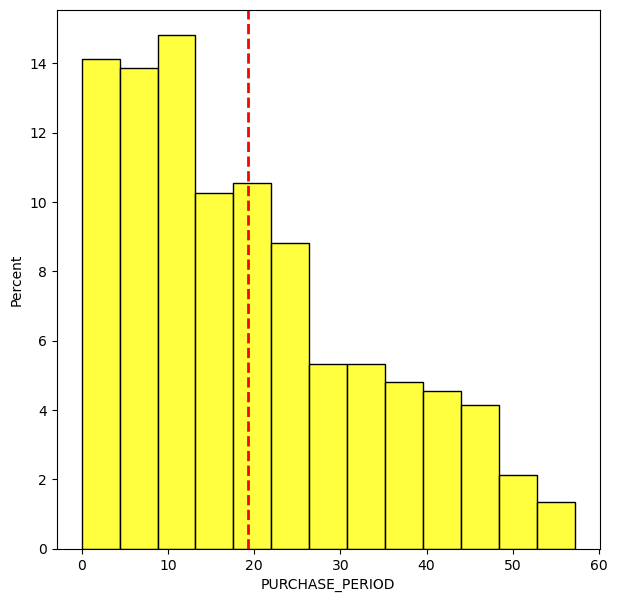

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
avg = df['PURCHASE_PERIOD'].mean()

ax = sns.histplot(data=df, x='PURCHASE_PERIOD', stat='percent', color='yellow')
ax.axvline(x=avg, color='red', ls="--", lw=2)
plt.show();

Didapatkan bahwa golden period untuk penjualan polis asuransi adalah 6 bulan. Oleh karena itu, dibuat kolom baru yang merupakan target untuk pemodelan yaitu 'Yes' apabila periode pembelian antar premi lebih kecil sama dengan 6 bulan, dan 'No' apabila tidak.

In [16]:
df['TARGET'] = np.where(df['PURCHASE_PERIOD'] > 6, 'No', 'Yes') # waktu untuk beli > 6, probabilitas untuk beli kedepannya semakin kecil
df.groupby(['PRODUCT_CODE_2', 'TARGET'])['PURCHASE_PERIOD'].describe().query('count > 0')

count       mean        std  min     25%    50%  \
PRODUCT_CODE_2 TARGET                                                    
P03            No      112.0  23.096429  12.390769  6.1  12.975  20.70   
               Yes      35.0   3.100000   1.905102  0.3   1.900   2.80   
P07            No      322.0  23.420497  13.348549  6.1  12.150  20.25   
               Yes      71.0   3.007042   1.820073  0.1   1.400   3.20   
P08            No      168.0  23.045238  12.833376  6.1  12.500  19.05   
               Yes      42.0   2.759524   1.648807  0.0   1.425   2.90   

                          75%   max  
PRODUCT_CODE_2 TARGET                
P03            No      32.050  55.7  
               Yes      4.900   6.0  
P07            No      33.075  55.8  
               Yes      4.450   5.9  
P08            No      33.125  57.2  
               Yes      3.900   6.0

Dataframe 'benedata' lalu digabungkan dengan 'df' dengan syarat CLIENT_ID yang sama. Dataframe baru ini dinamakan 'data'

In [17]:
data = df.merge(client_data, on = 'CLIENT_ID').merge(benedata, on = 'CLIENT_ID').merge(agent_data, on = 'AGENT_ID',suffixes=('','_Agent'))
data

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE_1 POLICY_STATUS  \
0    02015000024  12015010024       2014-12-10   2015-01-03       Inforce   
1    02015000062  12015010062       2014-12-16   2015-01-02       Inforce   
2    02015000087  12015010087       2014-12-18   2015-01-09       Inforce   
3    02015000088  12015010088       2014-12-18   2015-01-12       Inforce   
4    02018002785  12018040234       2018-03-28   2018-04-26       Inforce   
..           ...          ...              ...          ...           ...   
745  02019009354  12019080681       2019-08-09   2019-08-28       Inforce   
746  02019010240  12019090303       2019-08-29   2019-09-16       Inforce   
747  02019011032  12019090845       2019-09-16   2019-09-26       Inforce   
748  02019011802  12019100503       2019-10-03   2019-10-16       Inforce   
749  02019012018  12019100658       2019-10-08   2019-10-16       Inforce   

    PRODUCT_CODE_1 PRODUCT_TYPE PAYMENT_TYPE PAYMENT_TERM_1  PREMIUM_1  \
0              P12  Traditional       Single       Annually  1601500.0   
1              P09  Unit-Linked      Regular  Semi-Annually    16200.0   
2              P12  Traditional      Regular       Annually   180000.0   
3              P12  Traditional       Single       Annually  7500000.0   
4              P09  Unit-Linked      Regular  Semi-Annually    40000.0   
..             ...          ...          ...            ...        ...   
745            P17  Traditional      Regular  Semi-Annually    16200.0   
746            P09  Unit-Linked      Regular        Monthly     3300.0   
747            P17  Traditional      Regular      Quarterly    17500.0   
748            P09  Unit-Linked      Regular       Annually    30000.0   
749            P12  Traditional      Regular      Quarterly    38300.0   

     RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER ISSUE_DATE_2  \
0              3  3201202039                 2               1   2016-11-16   
1              2  3201303041                 2               1   2019-02-25   
2              2  3201405003                 2               1   2015-11-06   
3              2  3201401012                 2               1   2017-12-07   
4              2  3201401012                 2               1   2018-09-08   
..           ...         ...               ...             ...          ...   
745            4  3201309011                 2               1   2019-10-30   
746            1  3201311009                 2               1   2019-11-25   
747            4  3201208034                 2               1   2019-12-20   
748            3  3201206030                 2               1   2019-11-29   
749            4  3201405062                 2               1   2019-11-14   

    PRODUCT_CODE_2  PREMIUM_2 PAYMENT_TERM_2  PURCHASE_PERIOD TARGET  GENDER  \
0              P08    37500.0      Quarterly             22.4     No    Male   
1              P07     7200.0  Semi-Annually             49.8     No    Male   
2              P08    32500.0      Quarterly              9.9     No    Male   
3              P08   175000.0  Semi-Annually             34.8     No    Male   
4              P07    27500.0      Quarterly              4.4    Yes  Female   
..             ...        ...            ...              ...    ...     ...   
745            P03   216000.0       Annually              2.1    Yes  Female   
746            P07     4000.0      Quarterly              2.3    Yes  Female   
747            P03    11700.0        Monthly              2.8    Yes    Male   
748            P07    25500.0      Quarterly              1.4    Yes    Male   
749            P08    25500.0      Quarterly              1.0    Yes    Male   

           DOB MARITAL_STATUS          LOCATION NATIONALITY  OCCUPATION  \
0   2004-02-12         Single          BATANGAS          PH    GOVT-CAR   
1   1985-01-06       Divorced            QUEZON          PH  MISSIONARY   
2   2002-10-19        Married             RIZAL          P

In [18]:
data.isnull().sum()

POLICY_ID                       0
CLIENT_ID                       0
APPLICATION_DATE                0
ISSUE_DATE_1                    0
POLICY_STATUS                   0
PRODUCT_CODE_1                  0
PRODUCT_TYPE                    0
PAYMENT_TYPE                    0
PAYMENT_TERM_1                  0
PREMIUM_1                       0
RIDER_COUNT                     0
AGENT_ID                        0
POLICY_OWNERSHIP                0
PURCHASE_ORDER                  0
ISSUE_DATE_2                    0
PRODUCT_CODE_2                  0
PREMIUM_2                       0
PAYMENT_TERM_2                  0
PURCHASE_PERIOD                 0
TARGET                          0
GENDER                          0
DOB                             0
MARITAL_STATUS                  0
LOCATION                        0
NATIONALITY                     0
OCCUPATION                      0
ANNUAL_INCOME                   0
SMOKER                          0
PAYMENT_METHOD                  0
CHANNEL       

Karena kolom 'TERMINATION_DATE' memiliki banyak value yang kosong, kolom tersebut dihapus.

In [19]:
data.drop(columns=['TERMINATION_DATE'], inplace=True)
data

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE_1 POLICY_STATUS  \
0    02015000024  12015010024       2014-12-10   2015-01-03       Inforce   
1    02015000062  12015010062       2014-12-16   2015-01-02       Inforce   
2    02015000087  12015010087       2014-12-18   2015-01-09       Inforce   
3    02015000088  12015010088       2014-12-18   2015-01-12       Inforce   
4    02018002785  12018040234       2018-03-28   2018-04-26       Inforce   
..           ...          ...              ...          ...           ...   
745  02019009354  12019080681       2019-08-09   2019-08-28       Inforce   
746  02019010240  12019090303       2019-08-29   2019-09-16       Inforce   
747  02019011032  12019090845       2019-09-16   2019-09-26       Inforce   
748  02019011802  12019100503       2019-10-03   2019-10-16       Inforce   
749  02019012018  12019100658       2019-10-08   2019-10-16       Inforce   

    PRODUCT_CODE_1 PRODUCT_TYPE PAYMENT_TYPE PAYMENT_TERM_1  PREMIUM_1  \
0              P12  Traditional       Single       Annually  1601500.0   
1              P09  Unit-Linked      Regular  Semi-Annually    16200.0   
2              P12  Traditional      Regular       Annually   180000.0   
3              P12  Traditional       Single       Annually  7500000.0   
4              P09  Unit-Linked      Regular  Semi-Annually    40000.0   
..             ...          ...          ...            ...        ...   
745            P17  Traditional      Regular  Semi-Annually    16200.0   
746            P09  Unit-Linked      Regular        Monthly     3300.0   
747            P17  Traditional      Regular      Quarterly    17500.0   
748            P09  Unit-Linked      Regular       Annually    30000.0   
749            P12  Traditional      Regular      Quarterly    38300.0   

     RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER ISSUE_DATE_2  \
0              3  3201202039                 2               1   2016-11-16   
1              2  3201303041                 2               1   2019-02-25   
2              2  3201405003                 2               1   2015-11-06   
3              2  3201401012                 2               1   2017-12-07   
4              2  3201401012                 2               1   2018-09-08   
..           ...         ...               ...             ...          ...   
745            4  3201309011                 2               1   2019-10-30   
746            1  3201311009                 2               1   2019-11-25   
747            4  3201208034                 2               1   2019-12-20   
748            3  3201206030                 2               1   2019-11-29   
749            4  3201405062                 2               1   2019-11-14   

    PRODUCT_CODE_2  PREMIUM_2 PAYMENT_TERM_2  PURCHASE_PERIOD TARGET  GENDER  \
0              P08    37500.0      Quarterly             22.4     No    Male   
1              P07     7200.0  Semi-Annually             49.8     No    Male   
2              P08    32500.0      Quarterly              9.9     No    Male   
3              P08   175000.0  Semi-Annually             34.8     No    Male   
4              P07    27500.0      Quarterly              4.4    Yes  Female   
..             ...        ...            ...              ...    ...     ...   
745            P03   216000.0       Annually              2.1    Yes  Female   
746            P07     4000.0      Quarterly              2.3    Yes  Female   
747            P03    11700.0        Monthly              2.8    Yes    Male   
748            P07    25500.0      Quarterly              1.4    Yes    Male   
749            P08    25500.0      Quarterly              1.0    Yes    Male   

           DOB MARITAL_STATUS          LOCATION NATIONALITY  OCCUPATION  \
0   2004-02-12         Single          BATANGAS          PH    GOVT-CAR   
1   1985-01-06       Divorced            QUEZON          PH  MISSIONARY   
2   2002-10-19        Married             RIZAL          P

Kolom-kolom yang akan dipakai untuk pemodelan akan diubah tipenya sesuai dengan data-datanya.

In [20]:
cols = {
    'POLICY_ID': str,
    'CLIENT_ID': str,
    'APPLICATION_DATE': 'datetime64[ns]',
    'ISSUE_DATE_1': 'datetime64[ns]',
    'POLICY_STATUS': 'category',
    'PRODUCT_CODE_1': 'category',
    'PRODUCT_TYPE': 'category',
    'PAYMENT_TYPE': 'category',
    'PAYMENT_TERM_1': 'category',
    'PAYMENT_TERM_2': 'category',
    'PREMIUM_1': float,
    'RIDER_COUNT': int,
    'AGENT_ID': 'category',
    'POLICY_OWNERSHIP': int,
    'PURCHASE_ORDER': int,
    'ISSUE_DATE_2': 'datetime64[ns]',
    'PRODUCT_CODE_2': str,
    'PREMIUM_2': float,
    'PURCHASE_PERIOD': float,
    'TARGET': 'category',
    'GENDER': 'category',
    'DOB': 'datetime64[ns]',
    'MARITAL_STATUS': 'category',
    'LOCATION': str,
    'NATIONALITY': 'category',
    'OCCUPATION': str,
    'ANNUAL_INCOME': float,
    'SMOKER': 'category',
    'PAYMENT_METHOD': 'category',
    'CHANNEL': 'category',
    'TOTAL_COVERAGE': float,
    'BENEFICIARY_TYPE_PRIMARY': int,
    'BENEFICIARY_TYPE_SECONDARY': int,
    'DOB_Agent': 'datetime64[ns]',
    'MARITAL_STATUS_Agent': 'category',
    'TEAM_CODE': str,
    'CONTRACT_DATE': 'datetime64[ns]',
    'AGENT_STATUS': 'category',
    'FIRST_YEAR_COMMISSION': float,
}

data = data.astype(cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   POLICY_ID                   750 non-null    object        
 1   CLIENT_ID                   750 non-null    object        
 2   APPLICATION_DATE            750 non-null    datetime64[ns]
 3   ISSUE_DATE_1                750 non-null    datetime64[ns]
 4   POLICY_STATUS               750 non-null    category      
 5   PRODUCT_CODE_1              750 non-null    category      
 6   PRODUCT_TYPE                750 non-null    category      
 7   PAYMENT_TYPE                750 non-null    category      
 8   PAYMENT_TERM_1              750 non-null    category      
 9   PREMIUM_1                   750 non-null    float64       
 10  RIDER_COUNT                 750 non-null    int32         
 11  AGENT_ID                    750 non-null    category      

# Features Engineering

Dibawah merupakan proses untuk mengubah periode pembayaran premi menjadi jumlah per bulan (untuk kedua produk). Selanjutnya merupakan proses pembuatan kolom baru yaitu jumlah premi tahunan per produk (untuk kedua produk).

In [21]:
frequency_mapping = {
    'Annually': 1,
    'Semi-Annually': 2,
    'Quarterly': 4,
    'Monthly': 12
}

data['TERM_MAPPED_1'] = data['PAYMENT_TERM_1'].map(frequency_mapping).astype(int)
data['TERM_MAPPED_2'] = data['PAYMENT_TERM_2'].map(frequency_mapping).astype(int)
data['ANNUALIZED_PREMIUM_1'] = data['TERM_MAPPED_1'] * data['PREMIUM_1']
data['ANNUALIZED_PREMIUM_2'] = data['TERM_MAPPED_2'] * data['PREMIUM_2']
data

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE_1 POLICY_STATUS  \
0    02015000024  12015010024       2014-12-10   2015-01-03       Inforce   
1    02015000062  12015010062       2014-12-16   2015-01-02       Inforce   
2    02015000087  12015010087       2014-12-18   2015-01-09       Inforce   
3    02015000088  12015010088       2014-12-18   2015-01-12       Inforce   
4    02018002785  12018040234       2018-03-28   2018-04-26       Inforce   
..           ...          ...              ...          ...           ...   
745  02019009354  12019080681       2019-08-09   2019-08-28       Inforce   
746  02019010240  12019090303       2019-08-29   2019-09-16       Inforce   
747  02019011032  12019090845       2019-09-16   2019-09-26       Inforce   
748  02019011802  12019100503       2019-10-03   2019-10-16       Inforce   
749  02019012018  12019100658       2019-10-08   2019-10-16       Inforce   

    PRODUCT_CODE_1 PRODUCT_TYPE PAYMENT_TYPE PAYMENT_TERM_1  PREMIUM_1  \
0              P12  Traditional       Single       Annually  1601500.0   
1              P09  Unit-Linked      Regular  Semi-Annually    16200.0   
2              P12  Traditional      Regular       Annually   180000.0   
3              P12  Traditional       Single       Annually  7500000.0   
4              P09  Unit-Linked      Regular  Semi-Annually    40000.0   
..             ...          ...          ...            ...        ...   
745            P17  Traditional      Regular  Semi-Annually    16200.0   
746            P09  Unit-Linked      Regular        Monthly     3300.0   
747            P17  Traditional      Regular      Quarterly    17500.0   
748            P09  Unit-Linked      Regular       Annually    30000.0   
749            P12  Traditional      Regular      Quarterly    38300.0   

     RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER ISSUE_DATE_2  \
0              3  3201202039                 2               1   2016-11-16   
1              2  3201303041                 2               1   2019-02-25   
2              2  3201405003                 2               1   2015-11-06   
3              2  3201401012                 2               1   2017-12-07   
4              2  3201401012                 2               1   2018-09-08   
..           ...         ...               ...             ...          ...   
745            4  3201309011                 2               1   2019-10-30   
746            1  3201311009                 2               1   2019-11-25   
747            4  3201208034                 2               1   2019-12-20   
748            3  3201206030                 2               1   2019-11-29   
749            4  3201405062                 2               1   2019-11-14   

    PRODUCT_CODE_2  PREMIUM_2 PAYMENT_TERM_2  PURCHASE_PERIOD TARGET  GENDER  \
0              P08    37500.0      Quarterly             22.4     No    Male   
1              P07     7200.0  Semi-Annually             49.8     No    Male   
2              P08    32500.0      Quarterly              9.9     No    Male   
3              P08   175000.0  Semi-Annually             34.8     No    Male   
4              P07    27500.0      Quarterly              4.4    Yes  Female   
..             ...        ...            ...              ...    ...     ...   
745            P03   216000.0       Annually              2.1    Yes  Female   
746            P07     4000.0      Quarterly              2.3    Yes  Female   
747            P03    11700.0        Monthly              2.8    Yes    Male   
748            P07    25500.0      Quarterly              1.4    Yes    Male   
749            P08    25500.0      Quarterly              1.0    Yes    Male   

           DOB MARITAL_STATUS          LOCATION NATIONALITY  OCCUPATION  \
0   2004-02-12         Single          BATANGAS          PH    GOVT-CAR   
1   1985-01-06       Divorced            QUEZON          PH  MISSIONARY   
2   2002-10-19        Married             RIZAL          P

Berikut merupakan proses penghapusan kolom yang tidak akan dipakai untuk pemodelan.

In [22]:
drop_col = ['POLICY_STATUS', 'PAYMENT_TYPE', 'MARITAL_STATUS_Agent', 
            'SMOKER', 'DOB_Agent', 'AGENT_ID','TEAM_CODE','APPLICATION_DATE','PURCHASE_ORDER',
            'OCCUPATION','PAYMENT_TERM_1','PAYMENT_TERM_2','AGENT_STATUS','FIRST_YEAR_COMMISSION',
            'TERM_MAPPED_1', 'TERM_MAPPED_2','PREMIUM_1','PREMIUM_2','CONTRACT_DATE']
data.drop(columns=drop_col, inplace=True)
data

POLICY_ID    CLIENT_ID ISSUE_DATE_1 PRODUCT_CODE_1 PRODUCT_TYPE  \
0    02015000024  12015010024   2015-01-03            P12  Traditional   
1    02015000062  12015010062   2015-01-02            P09  Unit-Linked   
2    02015000087  12015010087   2015-01-09            P12  Traditional   
3    02015000088  12015010088   2015-01-12            P12  Traditional   
4    02018002785  12018040234   2018-04-26            P09  Unit-Linked   
..           ...          ...          ...            ...          ...   
745  02019009354  12019080681   2019-08-28            P17  Traditional   
746  02019010240  12019090303   2019-09-16            P09  Unit-Linked   
747  02019011032  12019090845   2019-09-26            P17  Traditional   
748  02019011802  12019100503   2019-10-16            P09  Unit-Linked   
749  02019012018  12019100658   2019-10-16            P12  Traditional   

     RIDER_COUNT  POLICY_OWNERSHIP ISSUE_DATE_2 PRODUCT_CODE_2  \
0              3                 2   2016-11-16            P08   
1              2                 2   2019-02-25            P07   
2              2                 2   2015-11-06            P08   
3              2                 2   2017-12-07            P08   
4              2                 2   2018-09-08            P07   
..           ...               ...          ...            ...   
745            4                 2   2019-10-30            P03   
746            1                 2   2019-11-25            P07   
747            4                 2   2019-12-20            P03   
748            3                 2   2019-11-29            P07   
749            4                 2   2019-11-14            P08   

     PURCHASE_PERIOD TARGET  GENDER        DOB MARITAL_STATUS  \
0               22.4     No    Male 2004-02-12         Single   
1               49.8     No    Male 1985-01-06       Divorced   
2                9.9     No    Male 2002-10-19        Married   
3               34.8     No    Male 1982-08-24       Divorced   
4                4.4    Yes  Female 1996-08-30        Married   
..               ...    ...     ...        ...            ...   
745              2.1    Yes  Female 1999-05-28         Single   
746              2.3    Yes  Female 2003-06-28      Separated   
747              2.8    Yes    Male 1990-04-15         Single   
748              1.4    Yes    Male 1992-07-05         Single   
749              1.0    Yes    Male 1998-05-13        Married   

             LOCATION NATIONALITY  ANNUAL_INCOME  PAYMENT_METHOD  \
0            BATANGAS          PH      1000900.0          Direct   
1              QUEZON          PH       180000.0          Direct   
2               RIZAL          PH      1000000.0          Direct   
3              MANILA          PH      5000000.0          Direct   
4    ORIENTAL MINDORO          PH      1000000.0          Direct   
..                ...         ...            ...             ...   
745           ISABELA          PH       180000.0  Single Premium   
746            MANILA          PH       200000.0          Direct   
747     CAMARINES SUR          PH      1000000.0          Direct   
748      METRO MANILA          PH       600000.0  Single Premium   
749            MANILA          PH      1700000.0  Single Premium   

           CHANNEL  TOTAL_COVERAGE  BENEFICIARY_TYPE_PRIMARY  \
0            Other       2700000.0                         2   
1    Agent Partner       1050000.0                         1   
2      Agent Staff       5890900.0                         1   
3      Agent Staff      45342100.0                         1   
4    Agent Partner       5200000.0                         1   
..             ...             ...                       ...   
745  Agent Partner       1000000.0                         1   
746  Agent Partner       3000000.0                         1   
747         Broker       3178000.0                         1   
748         Broker       1500000.0                         1   
749  Agent Partner     

In [23]:
def plot_correlation_heatmap(data):
    pearson = data.corr()
    shape = np.triu(pearson)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(pearson, mask=shape, annot=True, fmt='.1%', cmap='RdYlGn_r', cbar_kws={'shrink': 0.8},
                     vmin=-1, center=0, vmax=1, square=True, linewidths=0.1, linecolor='white')
    plt.show()

Dibawah merupakan heatmap untuk korelasi pearson pada data yang akan dipakai untuk modelling. Dapat dilihat bahwa kolom 'BENEFICIARY_TYPE_SECONDARY' berkorelasi kuat dengan kolom 'BENEFICIARY_TYPE_PRIMARY'. Selain itu, kolom 'ANNUALIZED_PREMIUM_1' dan 'ANNUALIZED_PREMIUM_2' memiliki korelasi kuat dengan kolom 'ANNUAL_INCOME'

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\1305969554.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson = data.corr()


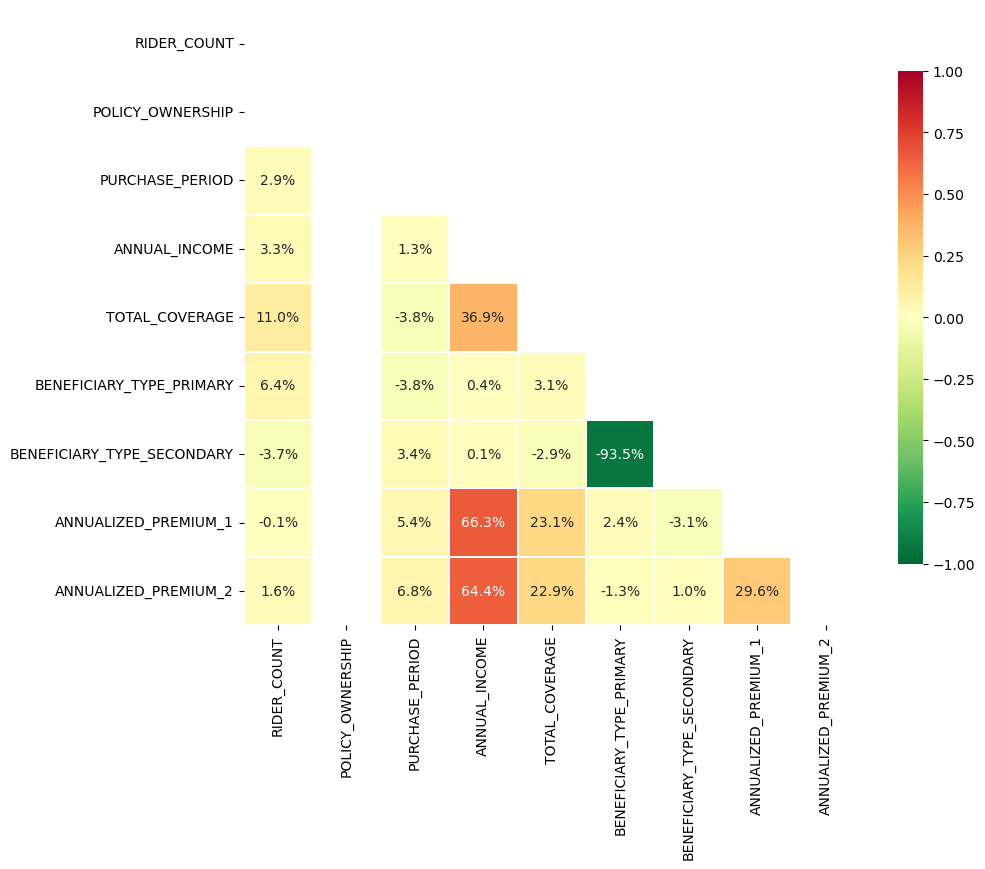

In [24]:
plot_correlation_heatmap(data)

Dibawah merupakan heatmap PPScore untuk data yang akan dipakai dalam pemodelan.

C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\micha\anaconda3\lib\s

Predictive Power Score Matrix:


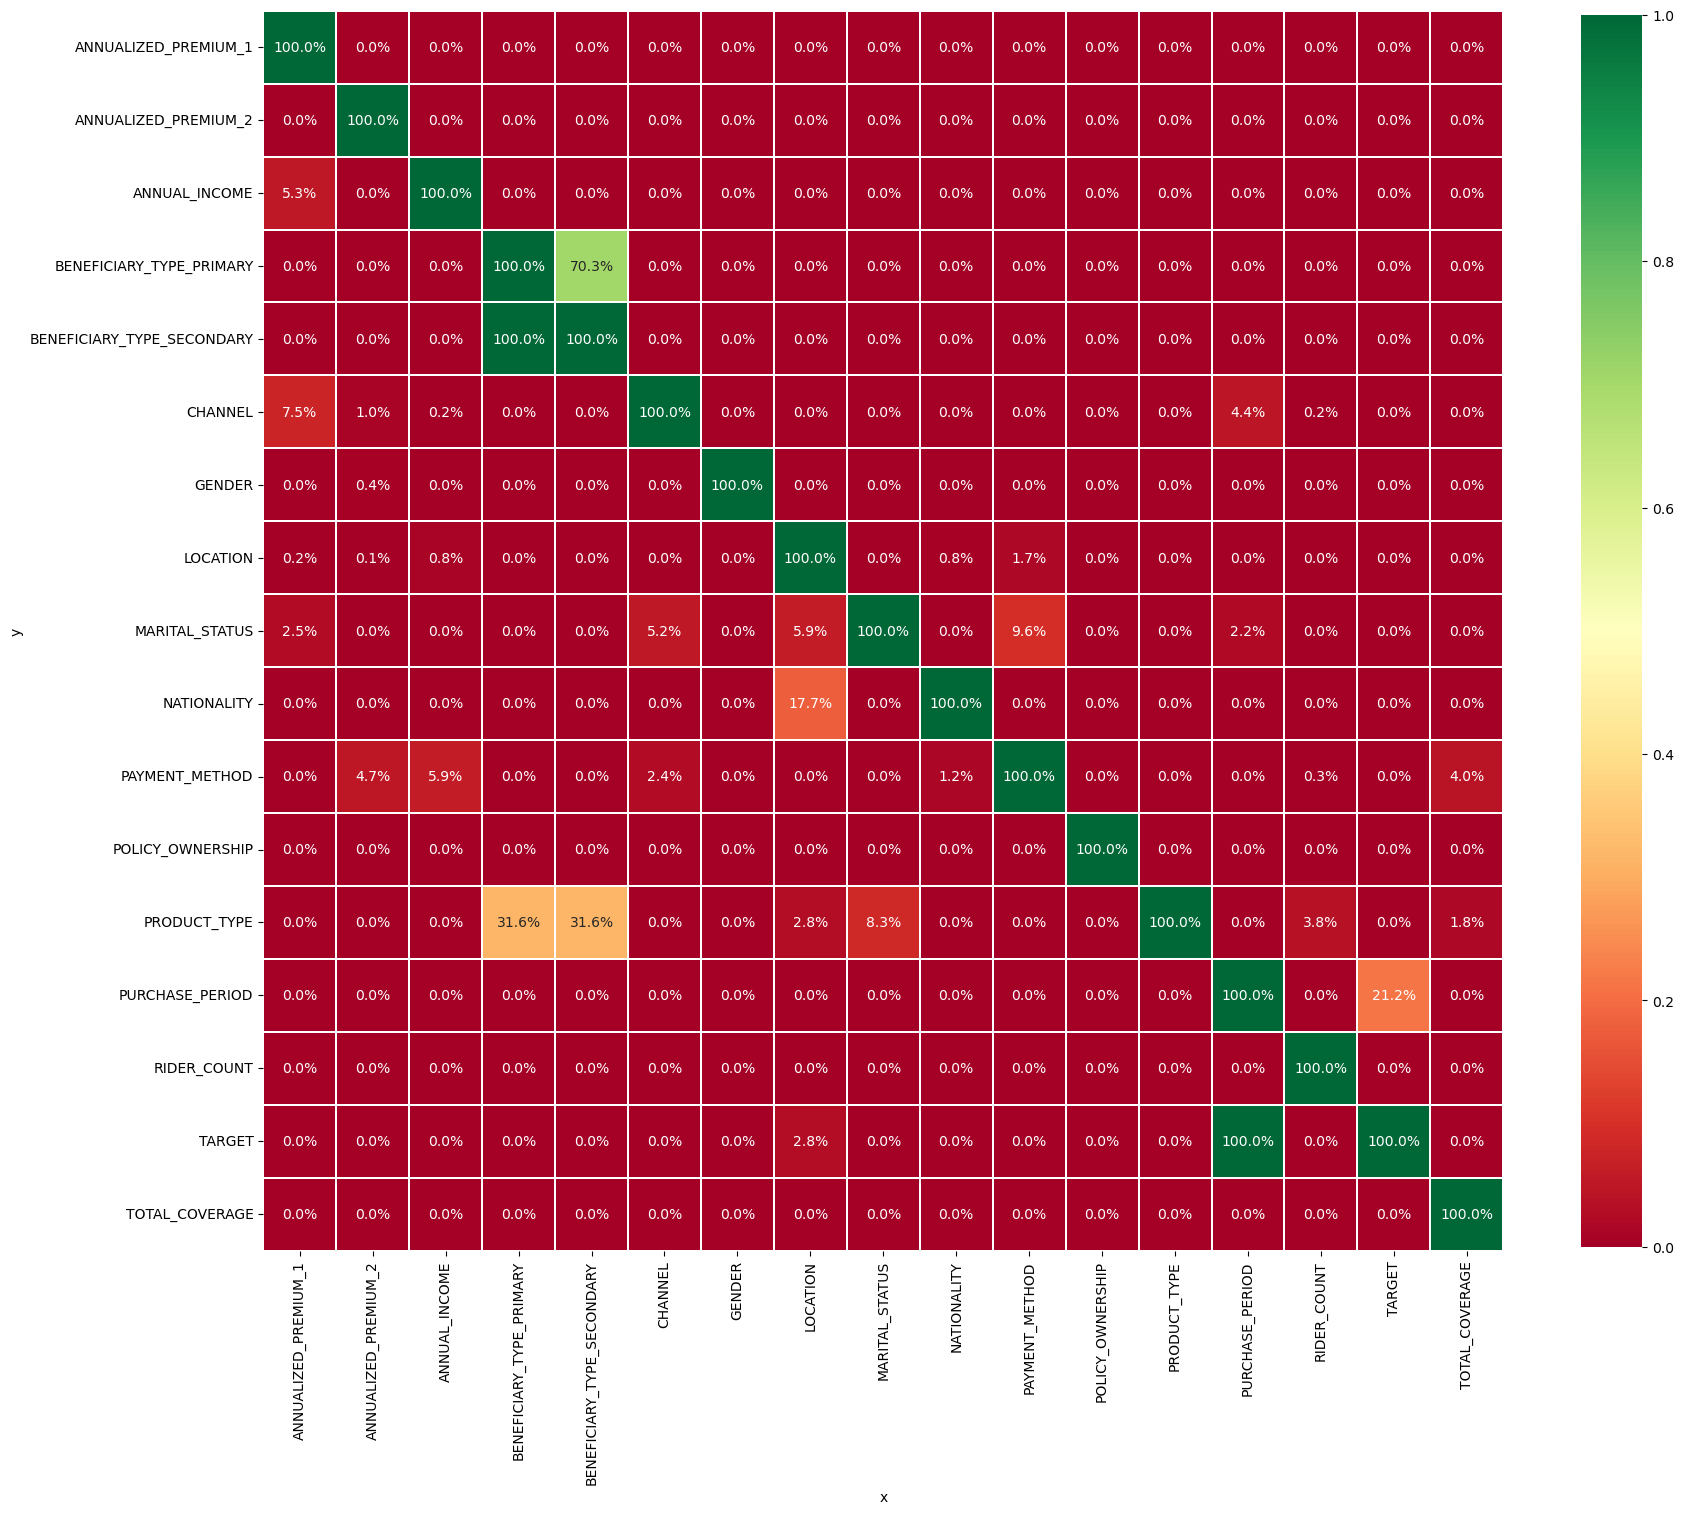

In [25]:
features = [col for col in data.columns if col not in ('POLICY_ID','CLIENT_ID','ISSUE_DATE_1','ISSUE_DATE_2',
                                                       'APPLICATION_DATE','DOB','PRODUCT_CODE_1',
                                                       'PRODUCT_CODE_2','CONTRACT_DATE','TARGET')]
predictive_power(data, features, 'TARGET')

In [26]:
import datetime as dt

data['ISSUE_DATEDATE_1'] = data['ISSUE_DATE_1'].dt.strftime('%m-%d')

### Ouliers Treatment

In [27]:
data = data[data.ANNUAL_INCOME != 50000000.0]

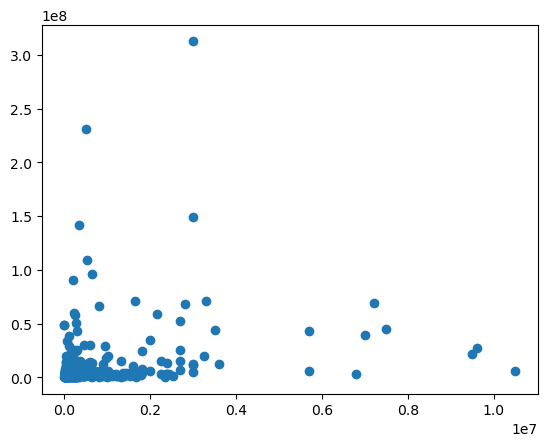

In [28]:
plt.scatter(data['ANNUALIZED_PREMIUM_1'], data['TOTAL_COVERAGE'])
plt.show()

### Final Data

In [29]:
data

POLICY_ID    CLIENT_ID ISSUE_DATE_1 PRODUCT_CODE_1 PRODUCT_TYPE  \
0    02015000024  12015010024   2015-01-03            P12  Traditional   
1    02015000062  12015010062   2015-01-02            P09  Unit-Linked   
2    02015000087  12015010087   2015-01-09            P12  Traditional   
3    02015000088  12015010088   2015-01-12            P12  Traditional   
4    02018002785  12018040234   2018-04-26            P09  Unit-Linked   
..           ...          ...          ...            ...          ...   
745  02019009354  12019080681   2019-08-28            P17  Traditional   
746  02019010240  12019090303   2019-09-16            P09  Unit-Linked   
747  02019011032  12019090845   2019-09-26            P17  Traditional   
748  02019011802  12019100503   2019-10-16            P09  Unit-Linked   
749  02019012018  12019100658   2019-10-16            P12  Traditional   

     RIDER_COUNT  POLICY_OWNERSHIP ISSUE_DATE_2 PRODUCT_CODE_2  \
0              3                 2   2016-11-16            P08   
1              2                 2   2019-02-25            P07   
2              2                 2   2015-11-06            P08   
3              2                 2   2017-12-07            P08   
4              2                 2   2018-09-08            P07   
..           ...               ...          ...            ...   
745            4                 2   2019-10-30            P03   
746            1                 2   2019-11-25            P07   
747            4                 2   2019-12-20            P03   
748            3                 2   2019-11-29            P07   
749            4                 2   2019-11-14            P08   

     PURCHASE_PERIOD TARGET  GENDER        DOB MARITAL_STATUS  \
0               22.4     No    Male 2004-02-12         Single   
1               49.8     No    Male 1985-01-06       Divorced   
2                9.9     No    Male 2002-10-19        Married   
3               34.8     No    Male 1982-08-24       Divorced   
4                4.4    Yes  Female 1996-08-30        Married   
..               ...    ...     ...        ...            ...   
745              2.1    Yes  Female 1999-05-28         Single   
746              2.3    Yes  Female 2003-06-28      Separated   
747              2.8    Yes    Male 1990-04-15         Single   
748              1.4    Yes    Male 1992-07-05         Single   
749              1.0    Yes    Male 1998-05-13        Married   

             LOCATION NATIONALITY  ANNUAL_INCOME  PAYMENT_METHOD  \
0            BATANGAS          PH      1000900.0          Direct   
1              QUEZON          PH       180000.0          Direct   
2               RIZAL          PH      1000000.0          Direct   
3              MANILA          PH      5000000.0          Direct   
4    ORIENTAL MINDORO          PH      1000000.0          Direct   
..                ...         ...            ...             ...   
745           ISABELA          PH       180000.0  Single Premium   
746            MANILA          PH       200000.0          Direct   
747     CAMARINES SUR          PH      1000000.0          Direct   
748      METRO MANILA          PH       600000.0  Single Premium   
749            MANILA          PH      1700000.0  Single Premium   

           CHANNEL  TOTAL_COVERAGE  BENEFICIARY_TYPE_PRIMARY  \
0            Other       2700000.0                         2   
1    Agent Partner       1050000.0                         1   
2      Agent Staff       5890900.0                         1   
3      Agent Staff      45342100.0                         1   
4    Agent Partner       5200000.0                         1   
..             ...             ...                       ...   
745  Agent Partner       1000000.0                         1   
746  Agent Partner       3000000.0                         1   
747         Broker       3178000.0                         1   
748         Broker       1500000.0                         1   
749  Agent Partner     

# EDA

Berikut merupakan EDA yang dapat dikatakan cukup lengkap yang dihasilkan oleh ydata_profiling. Variabel-variabel yang akan dipakai untuk pemodelan menunjukkan variasi yang cukup bagus dan tidak uniform.

In [30]:
from ydata_profiling import ProfileReport

profile = ProfileReport(data, title = 'Data Profiling Report', explorative = False, minimal = True)
profile

C:\Users\micha\anaconda3\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\micha\AppData\Roaming\Python\Python39\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
frequency_mapping = {
    'Annually': 1,
    'Semi-Annually': 2,
    'Quarterly': 4,
    'Monthly': 12
}

data3['TERM_MAPPED'] = data3['PAYMENT_TERM'].map(frequency_mapping).astype(int)
data3['ANNUALIZED_PREMIUM'] = data3['TERM_MAPPED'] * data3['PREMIUM']
data3.head()

POLICY_ID    CLIENT_ID APPLICATION_DATE ISSUE_DATE POLICY_STATUS  \
0  02015000001  12015010001       2014-12-02 2015-01-01       Inforce   
1  02015000002  12015010002       2014-12-02 2015-01-01       Inforce   
2  02015000003  12015010003       2014-12-04 2015-01-03       Inforce   
3  02015005464  12015010003       2015-10-25 2015-11-01       Inforce   
4  02016000731  12015010003       2016-01-22 2016-02-03       Inforce   

  PRODUCT_CODE PRODUCT_TYPE PAYMENT_TYPE   PAYMENT_TERM    PREMIUM  \
0          P01  Unit-Linked       Single       Annually  4061000.0   
1          P02  Unit-Linked      Regular      Quarterly    31300.0   
2          P03  Unit-Linked       Single       Annually  1400000.0   
3          P03  Unit-Linked      Regular      Quarterly    37500.0   
4          P03  Unit-Linked      Regular  Semi-Annually    55000.0   

   RIDER_COUNT    AGENT_ID  POLICY_OWNERSHIP  PURCHASE_ORDER  TERM_MAPPED  \
0            5  3201207023                 1               1            1   
1            4  3201302026                 1               1            4   
2            2  3201310043                 3               1            1   
3            3  3201306038                 3               2            4   
4            1  3201209034                 3               3            2   

   ANNUALIZED_PREMIUM  
0           4061000.0  
1            125200.0  
2           1400000.0  
3            150000.0  
4            110000.0

In [32]:
data3['ANNUALIZED_PREMIUM'].max()

4939212500.0

In [33]:
data3['Year'] = data3.ISSUE_DATE.dt.year

In [34]:
cols = {
    'Year': 'category'
}

data3= data3.astype(cols)

In [35]:
data4 = data3[data3.ANNUALIZED_PREMIUM <= 412500.0]

Berikut merupakan persebaran dari premi tahunan per produk.

<Axes: xlabel='PRODUCT_CODE', ylabel='ANNUALIZED_PREMIUM'>

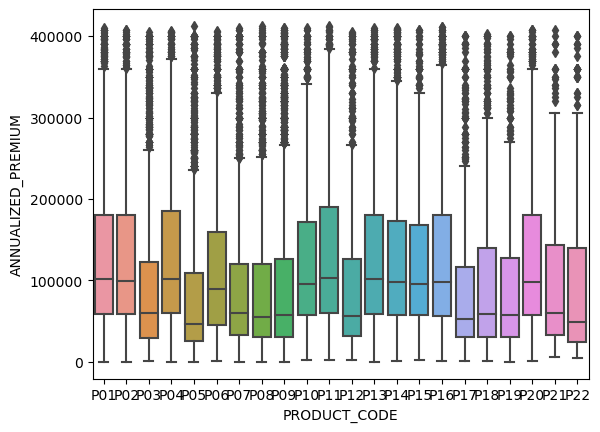

In [36]:
sns.boxplot(x=data4['PRODUCT_CODE'], y=data4['ANNUALIZED_PREMIUM'])

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\1832918730.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data3['ANNUALIZED_PREMIUM'], hist=True, kde=True,


<Axes: xlabel='ANNUALIZED_PREMIUM', ylabel='Density'>

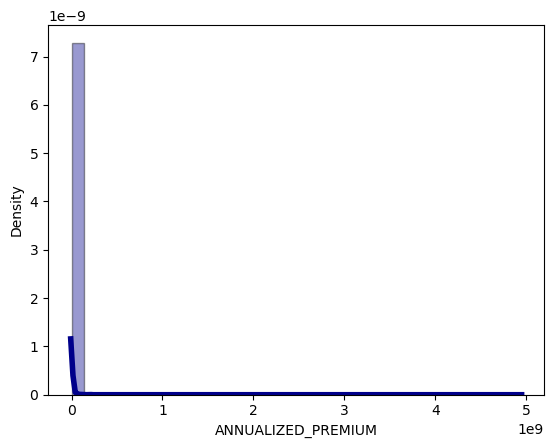

In [37]:
sns.distplot(data3['ANNUALIZED_PREMIUM'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\577066128.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_ = data3.groupby('Year').mean()


<Axes: title={'center': 'Mean'}, xlabel='Year', ylabel='Mean Premium'>

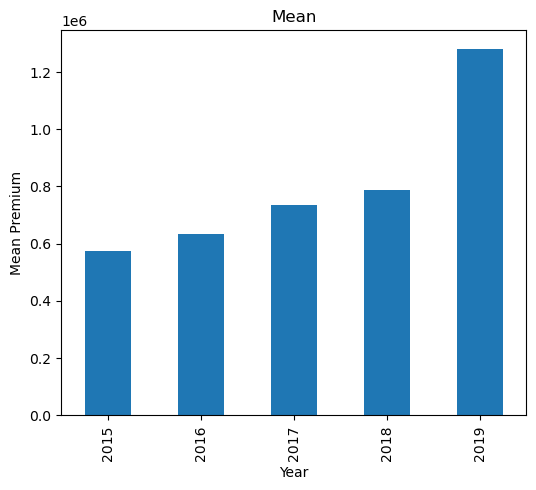

In [38]:
mean_ = data3.groupby('Year').mean()

mean_['ANNUALIZED_PREMIUM'].plot(kind='bar', title='Mean', ylabel='Mean Premium',
         xlabel='Year', figsize=(6, 5))

In [39]:
alt.data_transformers.disable_max_rows()

pcode_base = alt.Chart(data, title='Total Policies and Average Annualized Premium By Product 2 (P03,P07,P08)').encode(
    alt.X('PRODUCT_CODE_2:N', title='Products'),
    tooltip=[alt.Tooltip('count(PRODUCT_ID):Q', title='Total Products Sold'),
             alt.Tooltip('average(PURCHASE_PERIOD):Q', title='Average Policy Processing Period (days)'),
             alt.Tooltip('average(ANNUALIZED_PREMIUM_2):Q', title='Average Annual Premium'),],
)

pcode_bar = pcode_base.mark_bar(opacity=0.85).encode(
    alt.Y('count(POLICY_ID):Q', axis=alt.Axis(title='Total Product Sold', titleColor='#f2903a')),
    color=alt.Color('TARGET:N', scale=alt.Scale(
        scheme='goldred'), legend=alt.Legend(title='Target')),
)

pcode_line = pcode_base.mark_line(stroke='#800020', interpolate='monotone').encode(
    alt.Y('average(ANNUALIZED_PREMIUM_2)', axis=alt.Axis(title='Average Annualized Premium', titleColor='#800020'))
)

pcode_point = pcode_line.mark_circle(color='#800020')

alt.layer(pcode_bar, pcode_line + pcode_point).resolve_scale(
    y='independent'
).properties(
    width=600,
    height=200
)

alt.LayerChart(...)

==============================================================================================================================

**Bar:** menunjukkan total produk asuransi yang terjual untuk setiap produk berdasarkan kode produk kedua.

**Dot:** pada grafik garis menampilkan nilai rata-rata premi tahunan pada masing-masing product type.

==============================================================================================================================

In [40]:
cnat_base = alt.Chart(data, title='Average Annual Income and Total Coverage By Client\'s Nationality').encode(
    alt.X('NATIONALITY:N', title='Nationality'),
)

cnat_bar = cnat_base.mark_bar(color='#800020').encode(
    alt.Y('average(ANNUAL_INCOME):Q', axis=alt.Axis(title='Annual Income',
          titleColor='#800020')),
)

cnat_line = cnat_base.mark_line(stroke='goldenrod', interpolate='monotone').encode(
    alt.Y('count(CLIENT_ID):Q', axis = alt.Axis(title='Total Client',
                                                     titleColor='goldenrod')
))

cnat_point = cnat_line.mark_circle(color='goldenrod')

alt.layer(cnat_bar, cnat_line + cnat_point).resolve_scale(
    y='independent'
).properties(
    width=600,
    height=300
)

alt.LayerChart(...)

==============================================================================================================================

**Bar:** menunjukkan rata-rata pendapatan tahunan untuk setiap kewarganegaraan..

**Line:** menampilkan jumlah total klien untuk setiap kewarganegaraan.

**Dote:** menyoroti jumlah total klien pada titik-titik data tertentu.

==============================================================================================================================

## Transformasi Data

Dapat dilihat pada 4 grafik distribusi dibawah, persebaran value pada kolom ANNUAL_INCOME, TOTAL_COVERAGE, ANNUALIZED_PREMIUM_1, dan ANNUALIZED_PREMIUM_2 berbentuk right skew. Oleh karena itu, data-data tersebut ditransformasi secara logaritmik.

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\3971122945.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['ANNUAL_INCOME'], hist=True, kde=True,
C:\Users\micha\AppData\Local\Temp\ipykernel_16844\3971122945.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['TOTAL_COVERAGE'], hi

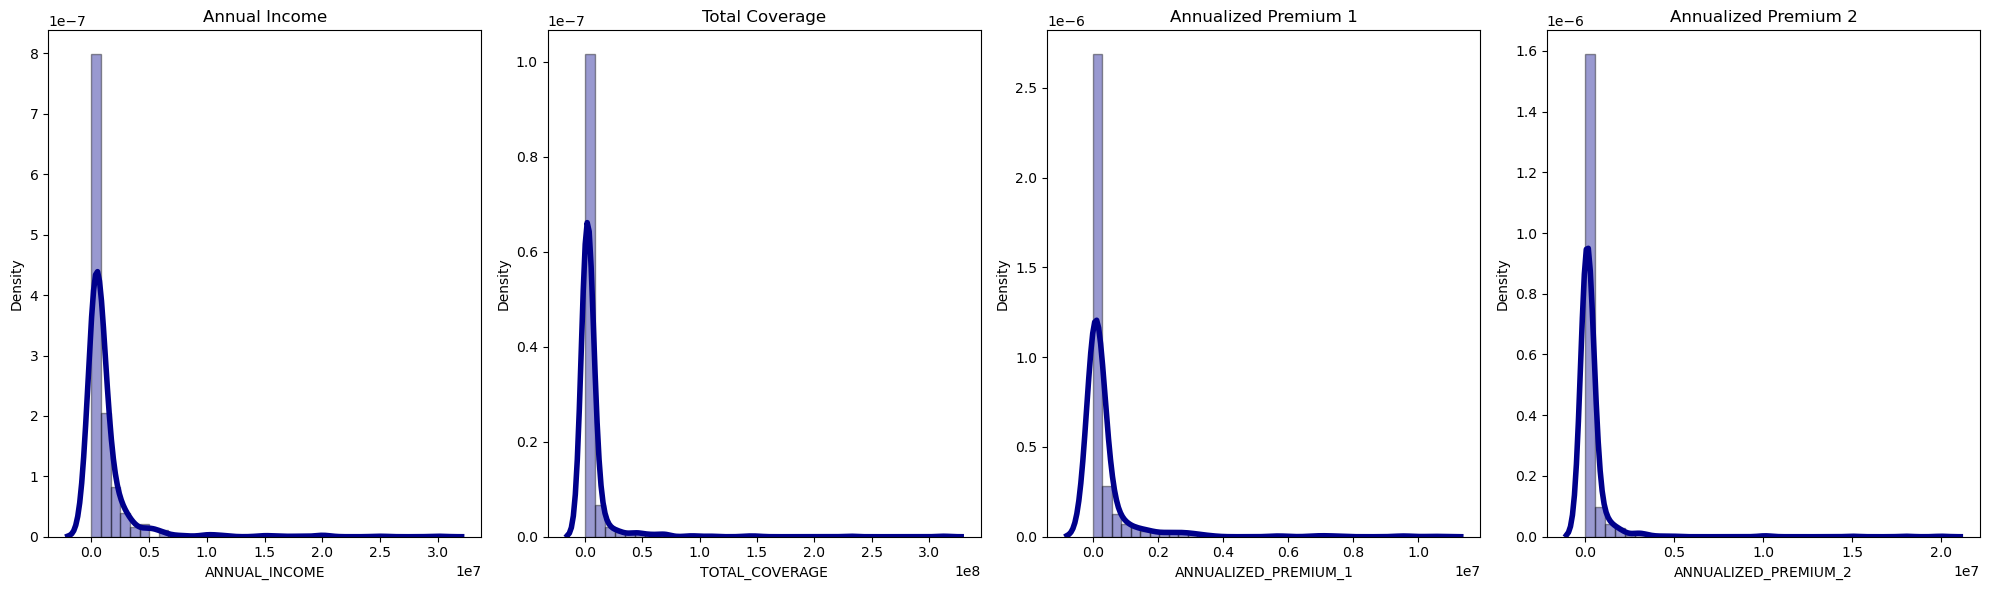

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

sns.distplot(data['ANNUAL_INCOME'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
axes[0].set_title('Annual Income')

sns.distplot(data['TOTAL_COVERAGE'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1])
axes[1].set_title('Total Coverage')

sns.distplot(data['ANNUALIZED_PREMIUM_1'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2])
axes[2].set_title('Annualized Premium 1')

sns.distplot(data['ANNUALIZED_PREMIUM_2'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[3])
axes[3].set_title('Annualized Premium 2')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [42]:
data['ANNUAL_INCOME'] = np.log(data['ANNUAL_INCOME'])
data['TOTAL_COVERAGE'] = np.log(data['TOTAL_COVERAGE'])
data['ANNUALIZED_PREMIUM_1'] = np.log(data['ANNUALIZED_PREMIUM_1'])
data['ANNUALIZED_PREMIUM_2'] = np.log(data['ANNUALIZED_PREMIUM_2'])

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\2103050638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ANNUAL_INCOME'] = np.log(data['ANNUAL_INCOME'])
C:\Users\micha\AppData\Local\Temp\ipykernel_16844\2103050638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TOTAL_COVERAGE'] = np.log(data['TOTAL_COVERAGE'])
C:\Users\micha\AppData\Local\Temp\ipykernel_16844\2103050638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Dapat dilihat, data setelah transformasi mengikuti curve bell yang lebih mirip dengan distribusi normal.

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\3259071580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ANNUALIZED_PREMIUM_2'] = data['ANNUALIZED_PREMIUM_2'].replace(-np.inf, 0)
C:\Users\micha\AppData\Local\Temp\ipykernel_16844\3259071580.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['ANNUAL_INCOME'], hist=True, kde=True,
C:\Users\micha\AppData\Local\Temp\ipykernel_16844\3259

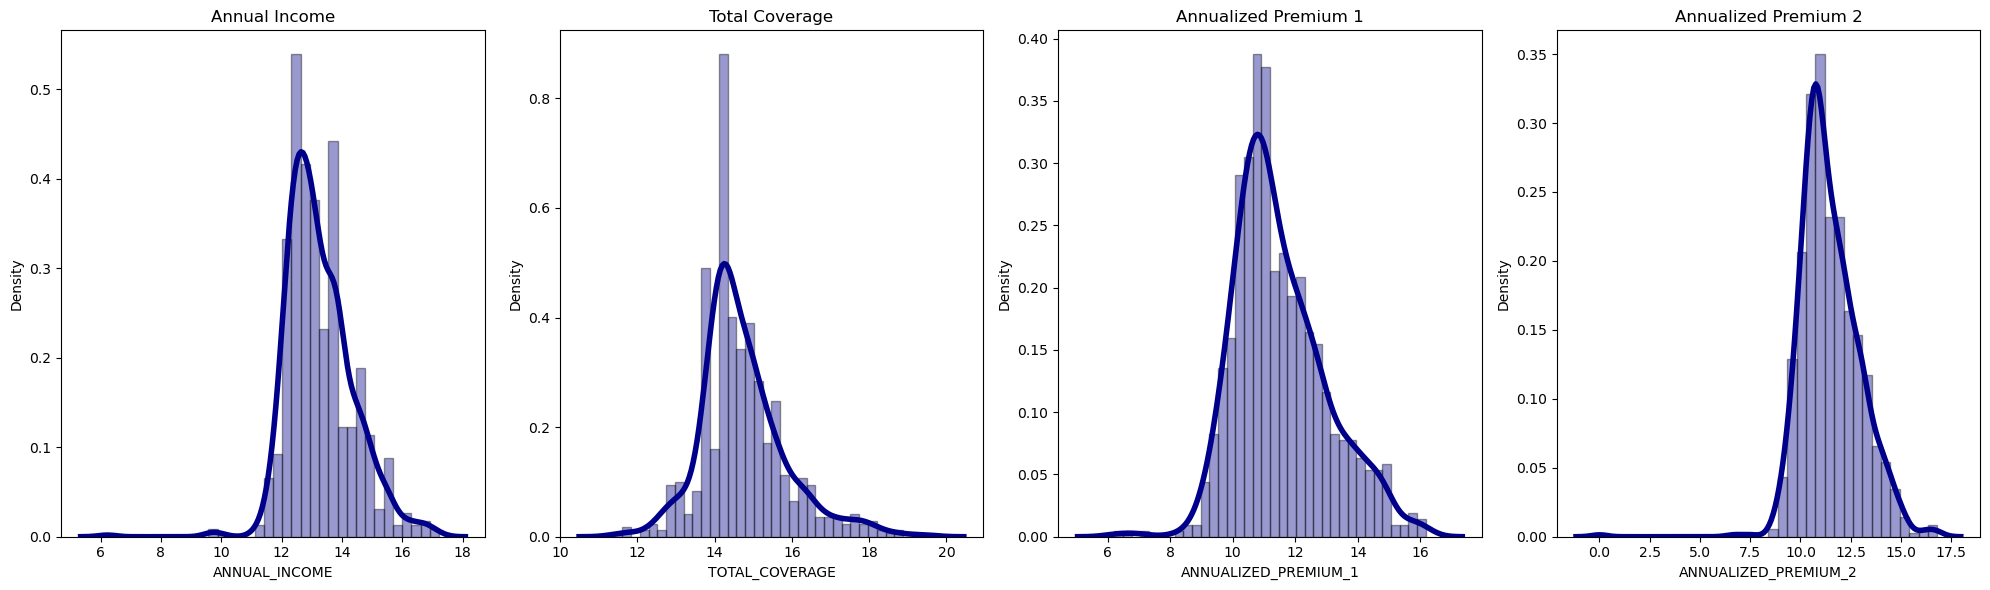

In [43]:
data['ANNUALIZED_PREMIUM_2'] = data['ANNUALIZED_PREMIUM_2'].replace(-np.inf, 0)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns

sns.distplot(data['ANNUAL_INCOME'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
axes[0].set_title('Annual Income')

sns.distplot(data['TOTAL_COVERAGE'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1])
axes[1].set_title('Total Coverage')

sns.distplot(data['ANNUALIZED_PREMIUM_1'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2])
axes[2].set_title('Annualized Premium 1')

sns.distplot(data['ANNUALIZED_PREMIUM_2'], hist=True, kde=True, 
             bins=int(180/5), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[3])
axes[3].set_title('Annualized Premium 2')

plt.tight_layout()
plt.show()

In [44]:
data['ANNUALIZED_PREMIUM_2'] = data['ANNUALIZED_PREMIUM_2'].replace(0, -np.inf)

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\2178044227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ANNUALIZED_PREMIUM_2'] = data['ANNUALIZED_PREMIUM_2'].replace(0, -np.inf)


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 0 to 749
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   POLICY_ID                   747 non-null    object        
 1   CLIENT_ID                   747 non-null    object        
 2   ISSUE_DATE_1                747 non-null    datetime64[ns]
 3   PRODUCT_CODE_1              747 non-null    category      
 4   PRODUCT_TYPE                747 non-null    category      
 5   RIDER_COUNT                 747 non-null    int32         
 6   POLICY_OWNERSHIP            747 non-null    int32         
 7   ISSUE_DATE_2                747 non-null    datetime64[ns]
 8   PRODUCT_CODE_2              747 non-null    object        
 9   PURCHASE_PERIOD             747 non-null    float64       
 10  TARGET                      747 non-null    category      
 11  GENDER                      747 non-null    category      

# SPLITTING DATA

Selanjutnya merupakan proses splitting data untuk training dan testing. Data training yang dipakai merupakan data yang dimana waktu pengeluaran produk ke dua merentang dari tahun 2015 hingga akhir 2018. Data yang digunakan untuk testing adalah sisanya (data dimana produk ke dua memiliki waktu pengeluaran pada tahun 2019 keatas).

In [46]:
test = data.loc[(data['ISSUE_DATE_2'] >= '2019-01-01')]
train = data.loc[(data['ISSUE_DATE_2'] < '2019-01-01')]

test.reset_index(inplace=True)
train.reset_index(inplace=True)

In [47]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         20 mins 05 secs
H2O_cluster_timezone:       Asia/Bangkok
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.2
H2O_cluster_version_age:    1 month and 7 days
H2O_cluster_name:           H2O_from_python_micha_jgmwyc
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    190.5 Mb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.16 final
--------------------------  -----------------------------

In [48]:
from h2o.automl import H2OAutoML

### Create Fold 

Dibawah merupakan proses pembuatan fold untuk proses cross validation pada data training. Kelompok kami menggunakan 5 fold untuk proses cross validation. Pembuatan fold dilakukan 2 kali untuk proses training model Propensity to Buy dan model Product Recommendation.

In [49]:
seed = 11
np.random.seed(seed)

cv_fold1 = train[['TARGET']].copy()
cv_fold1.reset_index(inplace=True)
cv_fold1['Random'] = np.random.random(len(train))

cv_fold1.sort_values(by=["TARGET", 'Random'], inplace=True, ignore_index=True)

kfold = 5
cv_fold1['CV_Fold_1'] = cv_fold1.index % kfold + 1

cv_fold1.sort_values(by='index', inplace=True, ignore_index=True)

train1 = train.assign(CV_Fold_1 = cv_fold1['CV_Fold_1'])
train1.groupby(['CV_Fold_1', 'TARGET']).agg(Count = ('CLIENT_ID','count'))

del cv_fold1

#train1.groupby(['CV_Fold_1', 'TARGET']).agg(Count = ('CLIENT_ID', 'count'))

In [50]:
seed = 11
np.random.seed(seed)

cv_fold = train[['PRODUCT_CODE_2']].copy()
cv_fold.reset_index(inplace=True)
cv_fold['Random'] = np.random.random(len(train))

cv_fold.sort_values(by=["PRODUCT_CODE_2", 'Random'], inplace=True, ignore_index=True)

kfold = 5
cv_fold['CV_Fold'] = cv_fold.index % kfold + 1

cv_fold.sort_values(by='index', inplace=True, ignore_index=True)

train = train.assign(CV_Fold = cv_fold['CV_Fold'])
train.groupby(['CV_Fold', 'PRODUCT_CODE_2']).agg(Count = ('CLIENT_ID','count'))

del cv_fold

### MODEL 1 (TARGET ~ Propensity to Buy) 

Dibawah merupakan proses pembuatan model pertama. Kelompok kami menggunakan model yang terbaik yang dihasilkan oleh fungsi AutoML dari package H2O.

In [51]:
start_time = pd.to_datetime('now', utc=True) + pd.Timedelta('07:00:00')

seed = 11
train_frame = h2o.H2OFrame(train1)

train_frame['TARGET'] = train_frame['TARGET']

timer(start_time, header='\nConverting DataFrame to H2O Frame')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Converting DataFrame to H2O Frame:
Start   : 2023-09-01 10:11:44 PM
Finish  : 2023-09-01 10:11:55 PM
Runtime : 00:00:11 



In [52]:
variables = ['PRODUCT_CODE_1',
             'ANNUALIZED_PREMIUM_1',
             'RIDER_COUNT',
             'GENDER',
             'MARITAL_STATUS',
             'NATIONALITY',
             'LOCATION',
             'ISSUE_DATE_1',
             'ANNUAL_INCOME',
             'PAYMENT_METHOD',
             'TOTAL_COVERAGE',
            ]
target = 'TARGET'

runtime = 60
algos = ['GLM', 'DRF', 'GBM', 'DeepLearning']
AML = H2OAutoML(max_runtime_secs=runtime, include_algos=algos, seed=seed)
AML.train(x=variables, y=target, training_frame=train_frame, fold_column = 'CV_Fold_1')

AML.leaderboard

AutoML progress: |█
22:12:02.484: Fold column CV_Fold_1 will be used for cross-validation. nfolds parameter will be ignored.

██████████████████████████████████████████████████████████████| 100%e) 100%


model_id                                           auc    logloss     aucpr    mean_per_class_error      rmse       mse
--------------------------------------------  --------  ---------  --------  ----------------------  --------  --------
GBM_grid_1_AutoML_4_20230901_221202_model_13  0.730498   0.485741  0.537122                0.315969  0.392767  0.154266
GBM_grid_1_AutoML_4_20230901_221202_model_11  0.727126   0.486594  0.481736                0.313069  0.395935  0.156765
GBM_grid_1_AutoML_4_20230901_221202_model_9   0.71793    0.491202  0.520054                0.323257  0.39666   0.157339
GBM_3_AutoML_4_20230901_221202                0.705436   0.491487  0.523976                0.317878  0.39515   0.156143
GBM_4_AutoML_4_20230901_221202                0.7038     0.506698  0.481991                0.339865  0.404405  0.163544
GLM_1_AutoML_4_20230901_221202                0.700441   0.495878  0.522456                0.332838  0.399079  0.159264
GBM_grid_1_AutoML_4_20230901_221202_model_1   0.698148   0.505414  0.446058                0.340956  0.405824  0.164693
GBM_2_AutoML_4_20230901_221202                0.697938   0.499496  0.510877                0.339493  0.398292  0.158636
GBM_grid_1_AutoML_4_20230901_221202_model_12  0.695781   0.494847  0.491324                0.338948  0.399345  0.159477
GBM_grid_1_AutoML_4_20230901_221202_model_4   0.68765    0.509072  0.399718                0.332552  0.407771  0.166277
[25 rows x 7 columns]

In [53]:
model0 = AML.leader
model0

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_4_20230901_221202_model_13


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    26                 26                          10900                  8            14           10.7692       22            32            28.4615

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.04808370779727791
RMSE: 0.21927997582378084
LogLoss: 0.19875260106147147
Mean Per-Class Error: 0.017252918866661707
AUC: 0.9973971889640812
AUCPR: 0.9910658750762342
Gini: 0.9947943779281625

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35267457830370236
       No    Yes    Error    Rate
-----  ----  -----  -------  -----------
No     351   6      0.0168   (6.0/357.0)
Yes    2     111    0.0177   (2.0/113.0)
Total  353   117    0.017    (8.0/470.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352675     0.965217  114
max f2                       0.273837     0.979203  122
max f0point5                 0.416049     0.964602  110
max accuracy                 0.416049     0.982979  110
max precision                0.943794     1         0
max recall                   0.273837     1         122
max specificity              0.943794     1         0
max absolute_mcc             0.352675     0.954207  114
max min_per_class_accuracy   0.352675     0.982301  114
max mean_per_class_accuracy  0.303766     0.984371  117
max tns                      0.943794     357       0
max fns                      0.943794     112       0
max fps                      0.018136     357       399
max tps                      0.273837     113       122
max tnr                      0.943794     1         0
max fnr                      0.943794     0.99115   0
max fpr                      0.018136     1         399
max tpr                      0.273837     1         122

Gains/Lift Table: Avg response rate: 24.04 %, avg score: 24.04 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0106383                   0.921361           4.15929  4.15929            1                0.933819   1                           0.933819            0.0442478       0.0442478                  315.929  315.929            0.0442478
2        0.0212766                   0.89619            4.15929  4.15929            1                0.90568    1                           0.919749            0.0442478       0.0884956                  315.929  315.929            0.0884956
3        0.0319149                   0.86262            4.15929  4.15929            1                0.875881   1                           0.905126            0.0442478       0.132743                   315.929  315.929            0.132743
4        0.0404255                   0.841051           4.15929  4.15929            1                0.852611   1                           0.89407             0.0353982       0.168142                   315.929  315.929            0.168142
5        0.0510638                   0.819611           4.15929  4.15929            1                0.828571   1                           0.880425

In [54]:
threshold = model0.F1(xval=True)[0][0]

In [55]:
train['TARGET'].value_counts()

No     357
Yes    113
Name: TARGET, dtype: int64

### Model 1 Prediction

Dibawah merupakan proses dan hasil dari prediksi dari model diatas. Model tersebut menghasilkan nilai f1 0.41 pada data testing, nilai akurasi 0.65, serta conversion rate sebesar 0.48.

In [56]:
test_frame = h2o.H2OFrame(test)

pred=model0.predict(test_frame)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [57]:
tgt = test_frame['TARGET'].as_data_frame()
tgt['TARGET'] = np.where(tgt['TARGET']=='No',0,1)

In [58]:
prob = pred['Yes'].as_data_frame()
prob['Predicted'] = np.where(prob['Yes']>threshold, 1,0)

In [59]:

tp = np.sum((prob['Predicted'] == 1) & (tgt['TARGET'] == 1))
fp = np.sum((prob['Predicted'] == 1) & (tgt['TARGET']== 0))
fn = np.sum((prob['Predicted'] == 0) & (tgt['TARGET'] == 1))
tn = np.sum((prob['Predicted'] == 0) & (tgt['TARGET'] == 0))
    
precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
acc = (tp + tn) / (tp + fp + tn + fn)

In [60]:
f1

0.40963855421686746

In [61]:
acc

0.6462093862815884

In [62]:
conversion_rate = np.sum(prob['Predicted'] == 1) / len(prob)
print("Conversion Rate:", conversion_rate)

Conversion Rate: 0.47653429602888087


# MODEL 2 (PRODUCT RECOMENDATION)

Dibawah merupakan proses pembuatan model  kedua. Metode yang dipakai sama dengan proses pembuatan model pertama.

In [63]:
start_time = pd.to_datetime('now', utc=True) + pd.Timedelta('07:00:00')

seed = 11
train_frame = h2o.H2OFrame(train)

train_frame['PRODUCT_CODE_2'] = train_frame['PRODUCT_CODE_2']

timer(start_time, header='\nConverting DataFrame to H2O Frame')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Converting DataFrame to H2O Frame:
Start   : 2023-09-01 10:19:58 PM
Finish  : 2023-09-01 10:20:08 PM
Runtime : 00:00:10 



In [64]:
variables = ['PRODUCT_CODE_1','ANNUALIZED_PREMIUM_1','RIDER_COUNT','GENDER',
             'MARITAL_STATUS','LOCATION','NATIONALITY',
             'ANNUAL_INCOME',
             'PAYMENT_METHOD','CHANNEL','TOTAL_COVERAGE']
target = 'PRODUCT_CODE_2'

runtime = 60
algos = ['GLM', 'DRF', 'GBM', 'XGBoost','DeepLearning']
AML2 = H2OAutoML(max_runtime_secs=runtime, include_algos=algos, seed=seed)
AML2.train(x=variables, y=target, training_frame=train_frame, fold_column = 'CV_Fold')

AML2.leaderboard

AutoML progress: |█
22:20:14.788: Fold column CV_Fold will be used for cross-validation. nfolds parameter will be ignored.
22:20:14.792: AutoML: XGBoost is not available; skipping it.
22:20:15.661: GLM_1_AutoML_5_20230901_222014 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: 61

██████████████████████████████████████████████████████████████| (done) 100%


model_id                                                mean_per_class_error    logloss       rmse         mse
----------------------------------------------------  ----------------------  ---------  ---------  ----------
GBM_grid_1_AutoML_5_20230901_222014_model_4                       0.00136612  0.0144905  0.0483481  0.00233754
DeepLearning_grid_1_AutoML_5_20230901_222014_model_3              0.00136612  0.0156853  0.0571978  0.00327159
GBM_grid_1_AutoML_5_20230901_222014_model_3                       0.00136612  0.0158866  0.049011   0.00240208
DeepLearning_grid_1_AutoML_5_20230901_222014_model_1              0.00136612  0.0293131  0.0461268  0.00212768
GBM_1_AutoML_5_20230901_222014                                    0.00136612  0.0126925  0.0467021  0.00218108
GBM_2_AutoML_5_20230901_222014                                    0.00136612  0.0135656  0.04705    0.0022137
GBM_grid_1_AutoML_5_20230901_222014_model_1                       0.00136612  0.0131127  0.0464578  0.00215833
GBM_grid_1_AutoML_5_20230901_222014_model_2                       0.00136612  0.0146849  0.0466326  0.0021746
GBM_4_AutoML_5_20230901_222014                                    0.00136612  0.0141736  0.0497465  0.00247471
DRF_1_AutoML_5_20230901_222014                                    0.00136612  0.0841241  0.107179   0.0114874
[19 rows x 5 columns]

In [65]:
model1 = AML2.leader
model1

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_5_20230901_222014_model_4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    241                723                         77082                  2            3            2.51314       3             4             3.73582

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 5.401455495894675e-08
RMSE: 0.00023241031594777964
LogLoss: 2.990926065172747e-05
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
P03    P07    P08    Error    Rate
-----  -----  -----  -------  -------
87     0      0      0        0 / 87
0      244    0      0        0 / 244
0      0      139    0        0 / 139
87     244    139    0        0 / 470

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.002337541808052496
RMSE: 0.04834813138118676
LogLoss: 0.01449046844376076
Mean Per-Class Error: 0.001366120218579235
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
P03    P07    P08    Error       Rate
-----  -----  -----  ----------  -------
87     0      0      0           0 / 87
1      243    0      0.00409836  1 / 244
0      0      139    0           0 / 139
88     243    139    0.00212766  1 / 470

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.997872
2    0.997872
3    1

Cross-Validation Metrics Summary: 
                         mean        sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  ----------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.997872    0.00475759  1             1             1             0.989362      1
auc                      nan         0           nan           nan           nan           nan           nan
err                      0.00212766  0.00475759  0             0             0             0.0106383     0
err_count                0.2         0.447214    0             0             0             1             0
logloss                  0.0149537   0.028887    2.97076e-05   0.00831099    0.000168262   0.066233      2.67336e-05
max_per_class_error      0.00408163  0.00912681  0             0             0             0.0204082     0
mean_per_class_accuracy  0.998639    0.00304227  1             1             1             0.993197      1
mean_per_class_error     0.00136054  0.00304227  0             0             0             0.00680272    0
mse                      0.00232443  0.00466357  1.54434e-08   0.000989271   1.18198e-06   0.0106316     3.14937e-08
pr_auc                   nan         0           nan           nan           nan           nan           nan
r2                       0.995013    0.0100327   1             0.997931      0.999997      0.977138      1
rmse                     0.0271903   0.0445129   0.000124271   0.0314527     0.00108719    0.10311 

### Model 2 Predict

Dibawah merupakan proses dan hasil prediksi dari model kedua. Hasil testing dari model kami menghasilkan hasil yang sempurna dimana model dapat merekomendasi produk yang sesuai dengan pembelian produk ke 2 untuk client-client yang terdapat pada data testing.

In [66]:
pred1=model1.predict(test_frame)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [67]:
prob1 = pred1[['P03','P07','P08']].as_data_frame()

In [68]:
prob1['Predicted'] = prob1[['P03', 'P07', 'P08']].idxmax(axis=1)
prob1

P03           P07           P08 Predicted
0    5.470399e-08  9.999999e-01  6.483585e-11       P07
1    1.352110e-07  9.999999e-01  8.857160e-11       P07
2    3.426468e-05  9.999657e-01  6.659987e-09       P07
3    1.370444e-07  9.999999e-01  5.290091e-11       P07
4    1.267810e-07  9.999999e-01  6.119444e-11       P07
..            ...           ...           ...       ...
272  9.999892e-01  4.636463e-06  6.206751e-06       P03
273  5.682118e-07  9.999994e-01  1.985268e-10       P07
274  9.999710e-01  2.758238e-05  1.428226e-06       P03
275  4.651537e-08  1.000000e+00  6.414990e-11       P07
276  8.826274e-06  1.072256e-09  9.999912e-01       P08

[277 rows x 4 columns]

In [69]:
test['PRODUCT_CODE_PREDICT'] = prob1['Predicted'].tolist()

C:\Users\micha\AppData\Local\Temp\ipykernel_16844\2545193329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PRODUCT_CODE_PREDICT'] = prob1['Predicted'].tolist()


In [70]:
test['Predicted'] = test['PRODUCT_CODE_2'] == test['PRODUCT_CODE_PREDICT']
print(test['Predicted'].sum() / len(test['Predicted'])) 

0.9963898916967509


C:\Users\micha\AppData\Local\Temp\ipykernel_16844\4065189623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted'] = test['PRODUCT_CODE_2'] == test['PRODUCT_CODE_PREDICT']
